# 4. Testing our model on real world data
Now that we have trained our model on some real world data, it is time to test it! We will run some queries on the learned model and see which points are most closely aligned with the query.

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, cycle
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import tqdm
import einops
import heapq
import math

import os
import sys
sys.path.append("../") # add parent directory to path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%matplotlib inline
from dataloaders.real_dataset import DeticDenseLabelledDataset
from grid_hash_model import GridCLIPModel

from misc import MLP

In [3]:
!export TOKENIZERS_PARALLELISM=false

## Load the models and the datasets

In this subsection, we load the dataset we prepared and the model we trained in the previous sections of this tutorial.

In [4]:
import pandas as pd
import pyntcloud
from pyntcloud import PyntCloud
import clip

DEVICE = "cuda"
#model, preprocess = clip.load("ViT-B/32", device=DEVICE)

from transformers import AutoProcessor, OwlViTModel

model = OwlViTModel.from_pretrained("google/owlvit-base-patch32").cuda()
preprocessor = AutoProcessor.from_pretrained("google/owlvit-base-patch32")
sentence_model = SentenceTransformer("all-mpnet-base-v2")

Some weights of the model checkpoint at google/owlvit-base-patch32 were not used when initializing OwlViTModel: ['class_head.logit_scale.weight', 'class_head.logit_shift.weight', 'class_head.logit_scale.bias', 'class_head.dense0.bias', 'box_head.dense2.weight', 'box_head.dense1.weight', 'class_head.logit_shift.bias', 'box_head.dense0.bias', 'layer_norm.weight', 'box_head.dense1.bias', 'box_head.dense0.weight', 'layer_norm.bias', 'box_head.dense2.bias', 'class_head.dense0.weight']
- This IS expected if you are initializing OwlViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OwlViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
training_data = torch.load("../meeting_room_data.pt")
max_coords, _ = training_data._label_xyz.max(dim=0)
min_coords, _ = training_data._label_xyz.min(dim=0)

In [6]:
from home_robot.utils.voxel import VoxelizedPointcloud
voxel_pcd = VoxelizedPointcloud()
voxel_pcd.add(points = training_data._label_xyz, 
              features = training_data._image_features,
              rgb = training_data._label_rgb,
              weights = training_data._label_weight)

In [31]:
label_model = GridCLIPModel(
    #image_rep_size=training_data[0]["clip_image_vector"].shape[-1],
    image_rep_size=512,
    #text_rep_size=training_data[0]["clip_vector"].shape[-1],
    text_rep_size=768,
    mlp_depth=1,
    mlp_width=600,
    log2_hashmap_size=20,
    num_levels=18,
    level_dim=8,
    per_level_scale=2,
    max_coords=max_coords,
    min_coords=min_coords,
).to(DEVICE)

#model_weights_path = "../cdslab/implicit_scene_label_model_latest_100.pt"
model_weights_path = "../meeting_room_model_weights/implicit_scene_label_model_latest.pt"
model_weights = torch.load(model_weights_path, map_location=DEVICE)
label_model.load_state_dict(model_weights["model"])
print(label_model)
print("Loaded model from", model_weights_path)

GridCLIPModel(
  (_grid_model): GridEncoder: input_dim=3 num_levels=18 level_dim=8 resolution=16 -> 2097152 per_level_scale=2.0000 params=(16044136, 8) gridtype=hash align_corners=False
  (_post_grid): MLP(
    (trunk): Sequential(
      (0): Linear(in_features=144, out_features=600, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=600, out_features=1280, bias=True)
    )
  )
  (_image_head): Identity()
)
Loaded model from ../meeting_room_model_weights/implicit_scene_label_model_latest.pt


In [7]:
batch_size = 30_000
points_dataloader = DataLoader(
    training_data._label_xyz, batch_size=batch_size, num_workers=10,
)
print("Created data loader", points_dataloader)

Created data loader <torch.utils.data.dataloader.DataLoader object at 0x7f12f0d522f0>


## Alignment calculation

We do some simple alignment calculation to find out the alignment between query and the environment our CLIP-Field is trained on. For any query, we calculate the CLIP-text embedding and the Sentence-BERT embedding. Then, we calculate the cosine similarity between the query embedding and the embeddings of the environment. The point with the highest cosine similarity is the most aligned point with the query.

In [32]:
def calculate_clip_and_st_embeddings_for_queries(queries):
    with torch.no_grad():
        #all_clip_queries = clip.tokenize(queries)
        #all_clip_tokens = model.encode_text(all_clip_queries.to(DEVICE)).float()
        inputs = preprocessor(
            text=[[query for query in queries]], return_tensors="pt"
        )
        inputs['input_ids'] = inputs['input_ids'].cuda()
        inputs['attention_mask'] = inputs['attention_mask'].cuda()
        all_clip_tokens = model.get_text_features(**inputs)
        all_clip_tokens = F.normalize(all_clip_tokens, p=2, dim=-1)
        all_st_tokens = torch.from_numpy(sentence_model.encode(queries))
        all_st_tokens = F.normalize(all_st_tokens, p=2, dim=-1).to(DEVICE)
    return all_clip_tokens, all_st_tokens

query = "Warm up my lunch"
clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries([query])
print("query =", query)
print("tokens shape =", clip_text_tokens.shape)

query = Warm up my lunch
tokens shape = torch.Size([1, 512])


We also define a method for finding alignment over the entire implicit field, which takes in a set of queries and a dataloader for points, and finds the "alignment" between the query and the embeddings of the points in the dataloader. We're defining alignment as the cosine similarity between the query and the point embeddings. If we have multiple embeddings (like from CLIP and SBert), we take a weighted average of them.

In [9]:
def find_alignment_over_model(voxel_pcd, queries):
    clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries(queries)
    points, features, _, _ = voxel_pcd.get_pointcloud()
    features = F.normalize(features, p=2, dim=-1)
    point_opacity = clip_text_tokens.detach().cpu() @ features.T
    
    print(point_opacity.shape)
    return point_opacity

In [33]:
def find_alignment_over_model(label_model, queries, dataloader, vision_weight = 1.0, text_weight = 10.0):
    clip_text_tokens, st_text_tokens = calculate_clip_and_st_embeddings_for_queries(queries)
    #negtives = ['objects', 'things', 'background', 'it', 'them', 'stuff', 'texture', 'some', 'every', 'any',
    #           'anything', 'something', 'everything', 'hello']
    #negative_clip_text_tokens, negative_st_text_tokens = calculate_clip_and_st_embeddings_for_queries(negtives)
    # We give different weights to visual and semantic alignment 
    # for different types of queries.
    point_opacity = []
    with torch.no_grad():
        for data in tqdm.tqdm(dataloader, total=len(dataloader)):
            # Find alignmnents with the vectors
            predicted_label_latents, predicted_image_latents = label_model(data.to(DEVICE))
            data_text_tokens = F.normalize(predicted_label_latents, p=2, dim=-1).to(DEVICE)
            data_visual_tokens = F.normalize(predicted_image_latents, p=2, dim=-1).to(DEVICE)
            text_alignment = data_text_tokens @ st_text_tokens.T
            visual_alignment = data_visual_tokens @ clip_text_tokens.T
            #negative_text_alignment = data_text_tokens @ negative_st_text_tokens.T
            #negative_visual_alignment = data_visual_tokens @ negative_clip_text_tokens.T
            #bs, qs = visual_alignment.shape
            #_, ns = negative_visual_alignment.shape
            #visual_relevancy_scores = (torch.exp(visual_alignment.unsqueeze(-1).expand(bs, qs, ns)) / 
            #    (torch.exp(visual_alignment.unsqueeze(-1).expand(bs, qs, ns)) + 
            #     torch.exp(negative_visual_alignment.unsqueeze(-2).expand(bs, qs, ns)))).min(-1).values
            #text_relevancy_scores = (torch.exp(text_alignment.unsqueeze(-1).expand(bs, qs, ns)) / 
            #    (torch.exp(text_alignment.unsqueeze(-1).expand(bs, qs, ns)) + 
            #     torch.exp(negative_text_alignment.unsqueeze(-2).expand(bs, qs, ns)))).min(-1).values
            #total_alignment = (text_weight * text_relevancy_scores) + vision_weight * visual_relevancy_scores
            total_alignment = (text_weight * text_alignment) + (vision_weight * visual_alignment)
            total_alignment /= (text_weight + vision_weight)
            point_opacity.append(total_alignment)

    point_opacity = torch.cat(point_opacity).T
    print(point_opacity.shape)
    return point_opacity


## Creating a PyntCloud object for visualization
We create a PyntCloud object for visualization in this part. We will use this object to visualize the results of our queries. **Note**: this might take a minute or two to run, but what is happening behind the scene is that the pointcloud is being downsampled to a manageable size for visualization.

In [34]:
merged_pcd = o3d.geometry.PointCloud()
merged_pcd.points = o3d.utility.Vector3dVector(training_data._label_xyz)
merged_pcd.colors = o3d.utility.Vector3dVector(training_data._label_rgb / 255)
merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.03)

print("Create pts result")
pts_result = np.concatenate((np.asarray(training_data._label_xyz), np.asarray(training_data._label_rgb)), axis=-1)

df = pd.DataFrame(
    # same arguments that you are passing to visualize_pcl
    data=pts_result,
    columns=["x", "y", "z", "red", "green", "blue"]
)
cloud = PyntCloud(df)

# write the point cloud
o3d.io.write_point_cloud(f"visualized_pointcloud/nyu_lab.ply", merged_downpcd)
print("Point cloud", cloud)

Create pts result
Point cloud PyntCloud
1967577 points with 3 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 2.47819185256958, -0.3589651882648468, -0.011958662420511246
Other attributes:



In [19]:
points, _, _, rgb = voxel_pcd.get_pointcloud()
merged_pcd = o3d.geometry.PointCloud()
merged_pcd.points = o3d.utility.Vector3dVector(points)
merged_pcd.colors = o3d.utility.Vector3dVector(rgb)
merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.03)

print("Create pts result")
pts_result = np.concatenate((np.asarray(training_data._label_xyz), np.asarray(training_data._label_rgb)), axis=-1)
#pts_result = np.concatenate((np.asarray(merged_downpcd.points), np.asarray(merged_downpcd.colors) * 255), axis=-1)

df = pd.DataFrame(
    # same arguments that you are passing to visualize_pcl
    data=pts_result,
    columns=["x", "y", "z", "red", "green", "blue"]
)
cloud = PyntCloud(df)

# write the point cloud
o3d.io.write_point_cloud(f"visualized_pointcloud/nyu_lab.ply", merged_downpcd)
print("Point cloud", cloud)

Create pts result
[Open3D WARNING] Write Ply clamped color value to valid range
Point cloud PyntCloud
1967577 points with 3 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 2.47819185256958, -0.3589651882648468, -0.011958662420511246
Other attributes:



In [35]:
# Now figure out the points that are far enough.

coordinates = np.array(cloud.points)
#ys = coordinates[:, 1]
#coordinates = coordinates[np.all([[ys < -0.2], [ys > -0.8]], axis = 0)[0]]
zs = coordinates[:, 2]
coordinates = coordinates[np.all([[zs < 1], [zs > 0]], axis = 0)[0]]
xs = coordinates[:, 0]
ys = coordinates[:, 1]
zs = coordinates[:, 2]
x_max = xs.max()
x_min = xs.min()
z_max = zs.max()
z_min = zs.min()
y_max = ys.max()
y_min = ys.min()

# This is the cutoff used for NYU kitchen
CUTOFF = 0.2

# Make a top down map for visualization. This step works best if the data is axis aligned.
def get_and_show_valid_points(coordinates, cutoff=CUTOFF, library=True):
    blockers = np.array([xs, zs]).T
    all_grid_points = np.array(np.meshgrid(np.arange(xs.min(), xs.max(), 0.2), np.arange(zs.min(), zs.max(), 0.2))).reshape(2, -1).T
    distance = np.linalg.norm(blockers[None, :, :] - all_grid_points[:, None, :], axis=2, ord=2)

    valid_points_index = distance.min(axis=1) > cutoff
    valid_points = all_grid_points[valid_points_index]

    ax = plt.subplot(111)
    ax.scatter(xs, zs, c="blue", alpha=0.25)
    ax.scatter(valid_points[:, 0], valid_points[:, 1], c="red", alpha = 0.25)
    ax.invert_xaxis()
    ax.set_aspect('equal', 'box')
    plt.show()
    return valid_points

#valid_points = get_and_show_valid_points(coordinates)
#print("Found some valid points:", valid_points.shape)

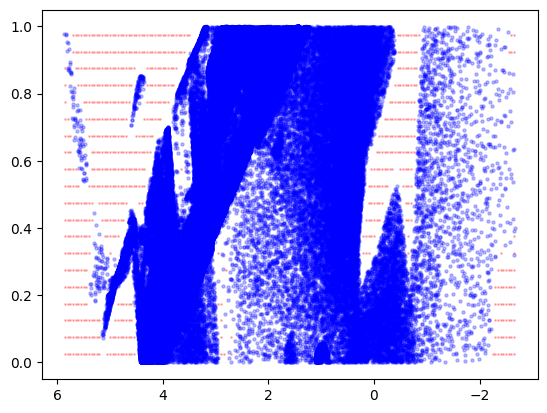

In [36]:
def pos2grid_id(cs, x, y):
    return int((x - x_min + cs / 2) // cs), int((z - z_min + cs / 2) // cs)


def grid_id2pos(cs, x, y):
    return x * cs + x_min + cs / 2, y * cs + z_min + cs / 2

scale = 0.05

xgs, zgs = int((x_max - x_min) // scale) + 1, int((z_max - z_min) // scale) + 1
obstacles = np.zeros((xgs, zgs))
#all_points = np.zeros((xgs, zgs), dtype=np.uint8)
#for x, y, z in zip(xs, ys, zs):
for coordinate in coordinates:
    x, y, z = coordinate[0], coordinate[1], coordinate[2]
    xind, yind = pos2grid_id(scale, x, z)
    obstacles[xind - 1 : xind + 1, yind - 1 : yind + 1] = True
    #all_points[xind - 1 : xind + 1, yind - 1 : yind + 1] = 1
    
valid_points = []
for i in range(obstacles.shape[0]):
    for j in range(obstacles.shape[1]):
        #if obstacles[i, j] == 0 or all_points[i, j] != 1:
        if obstacles[i, j]:
            continue
        valid_points.append(grid_id2pos(scale, i, j))
valid_points = np.array(valid_points)

ax = plt.subplot(111)
ax.scatter(xs, zs, c="blue", alpha=0.25, s = 5)
ax.scatter(valid_points[:, 0], valid_points[:, 1], c="red", alpha = 0.25, s = 1)
ax.invert_xaxis()
plt.savefig("map.jpg")
np.save("map.npy", obstacles)
plt.show()

## Finally, querying our model!

Now, let's figure out the queries and their closest points!

In [13]:
eval_data = pd.read_csv('../kitchen.csv')
queries = list(eval_data['query'])

xs, ys, zs, affords = list(eval_data['x']), list(eval_data['y']), list(eval_data['z']), list(eval_data['affordance'])
xyzs = torch.stack([torch.tensor(xs), torch.tensor(ys), torch.tensor(zs)], dim = 1)
alignment_q = find_alignment_over_model(label_model, queries, points_dataloader, vision_weight = 10.0, text_weight = 10.0)

  0%|                                                                                            | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 67%|███████████████████████████████████████████████████████▎                           | 22/33 [00:01<00:00, 29.05it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 24.57it/s]

torch.Size([21, 983312])


We can even visualize the "alignment" over the set of points! Let's visualize that for the first query.

In [46]:
queries = ['green bottle', 'tomato soup can', 'apple', 'blue bottle', 'yellow bottle', 'paper towel',
            'green tape', 'blue ball', 'toy drill', 'banana', 'green bowl', 'red bowl', 'red cup', 'green ball', 'green ball']
alignment_q = find_alignment_over_model(label_model, queries, points_dataloader, vision_weight = 10.0, text_weight = 10.0)
#alignment_q = find_alignment_over_model(voxel_pcd, queries)

  0%|                                                                                            | 0/66 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 82%|███████████████████████████████████████████████████████████████████▉               | 54/66 [00:01<00:00, 75.17it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 42.53it/s]

torch.Size([15, 1967577])


In [25]:
os.makedirs("visualized_pointcloud", exist_ok=True)

max_points = []
max_points_goto = []
mean_points = []
mean_point_goto = []
use_threshold = True
for query, q in zip(queries, alignment_q):
    alpha = q.detach().cpu().numpy()
    pts = voxel_pcd.get_pointcloud()[0].detach().cpu()

    # We are thresholding the points to get the top 0.01% of points.
    # Subsample if the number of points is too large.
    threshold = torch.quantile(q[::10, ...], 0.9999).cpu().item()

    # Normalize alpha
    a_norm = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    a_norm = torch.as_tensor(a_norm[..., np.newaxis])
    all_colors = torch.cat((a_norm, torch.zeros_like(a_norm), 1-a_norm), dim=1)

    if use_threshold:
        thres = alpha > threshold
        points = voxel_pcd.get_pointcloud()[0][thres]
        #max_point = pts[torch.topk(a_norm.squeeze(-1), k = 5).indices[-1]]
        max_point = pts[torch.topk(a_norm.squeeze(-1), k = 30).indices]
        #max_point = pts[torch.argmax(a_norm)]
        max_points.append(max_point)
        print(f"LOOKAT {query} {max_point.tolist()}")
        colors = all_colors[thres]
    else:
        points = training_data._label_xyz
        colors = all_colors
    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(points)
    merged_pcd.colors = o3d.utility.Vector3dVector(colors)
    merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.01)

LOOKAT green bottle [[2.539133071899414, -0.31206363439559937, -1.057726263999939], [2.6213231086730957, -0.30146360397338867, -1.2880754470825195], [2.586215019226074, -0.3045583963394165, -1.3042919635772705], [2.5838968753814697, -0.29888588190078735, -1.175752878189087], [2.6743524074554443, -0.3107415735721588, -1.3618948459625244], [2.6780505180358887, -0.24572084844112396, -1.2244852781295776], [2.6253530979156494, -0.29228445887565613, -1.2461501359939575], [2.6597418785095215, -0.15653100609779358, -1.0815999507904053], [2.728289842605591, -0.3059470057487488, -1.1757755279541016], [2.6259069442749023, -0.24435758590698242, -1.183963656425476], [2.6395974159240723, -0.20236080884933472, -1.1322368383407593], [2.6605660915374756, -0.2845778167247772, -1.2303768396377563], [2.637941598892212, -0.20583777129650116, -1.0909795761108398], [2.638141632080078, -0.24305760860443115, -1.136807918548584], [2.675962209701538, -0.3039584457874298, -1.1756691932678223], [2.6683876514434814

Finally, we are running all the queries and printing out the results. We are also visualizing the results in pointcloud files that you can find in `visualized_pointcloud` folder.

In [47]:
os.makedirs("visualized_pointcloud", exist_ok=True)

max_points = []
max_points_goto = []
mean_points = []
mean_point_goto = []
use_threshold = True
for query, q in zip(queries, alignment_q):
    alpha = q.detach().cpu().numpy()
    pts = training_data._label_xyz.detach().cpu()

    # We are thresholding the points to get the top 0.01% of points.
    # Subsample if the number of points is too large.
    threshold = torch.quantile(q[::10, ...], 0.9999).cpu().item()

    # Normalize alpha
    a_norm = (alpha - alpha.min()) / (alpha.max() - alpha.min())
    a_norm = torch.as_tensor(a_norm[..., np.newaxis])
    all_colors = torch.cat((a_norm, torch.zeros_like(a_norm), 1-a_norm), dim=1)

    if use_threshold:
        thres = alpha > threshold
        points = training_data._label_xyz[thres]
        #max_point = pts[torch.topk(a_norm.squeeze(-1), k = 5).indices[-1]]
        max_point = pts[torch.topk(a_norm.squeeze(-1), k = 30).indices]
        #max_point = pts[torch.argmax(a_norm)]
        max_points.append(max_point)
        print(f"LOOKAT {query} {max_point.tolist()}")
        colors = all_colors[thres]
    else:
        points = training_data._label_xyz
        colors = all_colors
    merged_pcd = o3d.geometry.PointCloud()
    merged_pcd.points = o3d.utility.Vector3dVector(points)
    merged_pcd.colors = o3d.utility.Vector3dVector(colors)
    merged_downpcd = merged_pcd.voxel_down_sample(voxel_size=0.01)
    #visual_str = "_visual" if visual else ""
    #thres_str = "_thres" if use_threshold else ""
    #o3d.io.write_point_cloud(f"visualized_pointcloud/model_nyu_kitchen_{query}{visual_str}{thres_str}.ply", merged_downpcd)

LOOKAT green bottle [[2.63608980178833, -0.21005629003047943, -1.1125547885894775], [2.638291358947754, -0.20876085758209229, -1.115088701248169], [2.648773431777954, -0.21179525554180145, -1.1225967407226562], [2.6561877727508545, -0.2292170524597168, -1.0846967697143555], [2.637840747833252, -0.32549744844436646, -1.0837733745574951], [2.638101100921631, -0.21175703406333923, -1.1100856065750122], [2.636294364929199, -0.22304534912109375, -1.0951651334762573], [2.64131760597229, -0.2333867847919464, -1.1930584907531738], [2.6224942207336426, -0.2842198312282562, -1.2578458786010742], [2.6384778022766113, -0.20596176385879517, -1.1250669956207275], [2.6608099937438965, -0.21976163983345032, -1.1451245546340942], [2.6155800819396973, -0.34650999307632446, -1.1396183967590332], [2.6127405166625977, -0.2841836214065552, -1.2763861417770386], [2.6355020999908447, -0.22388237714767456, -1.094393253326416], [2.6300721168518066, -0.21535024046897888, -1.1058133840560913], [2.663229465484619,

In [ ]:
# correctness = torch.linalg.norm((torch.stack(max_points)[:, [0, 2]] - xyzs[:, [0, 2]]), dim = -1) <= torch.tensor(affords)
np.array(queries)[torch.where(correctness)[0].numpy()], np.array(queries)[torch.where(~correctness)[0].numpy()], len(np.array(queries)[torch.where(correctness)[0].numpy()]) / len(correctness)

In [15]:
torch.linalg.norm((torch.stack(max_points)[:, [0, 2]] - xyzs[:, [0, 2]]), dim = -1)

NameError: name 'xyzs' is not defined

## Visualizing the results in the environment
Now that we have figured out where the maximizing points are, we can visualize the results to show the maximizing points in the environment. First, we have to add some boilerplate code for the visualization.

In [17]:
from pyntcloud.plot.common import get_colors

from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.cm as cm


def set_proper_aspect_ratio(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

def plot_with_matplotlib(cloud, 
            **kwargs):

    colors = get_colors(cloud, kwargs["use_as_color"], kwargs["cmap"])

    ptp = cloud.xyz.ptp()

    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=kwargs.get("elev", 0.0), azim=kwargs.get("azim", 90.0))

    ax.scatter(
        cloud.xyz[:, 0],
        cloud.xyz[:, 1],
        cloud.xyz[:, 2],
        marker="D",
        facecolors=colors / 255,
        alpha=0.25,
        zdir="z",
        depthshade=True,
        s=kwargs["initial_point_size"] or ptp / 10
    )


    if "text" in kwargs:
        for i, (points, text) in enumerate(kwargs["text"]):
            ax.text(points[0], points[1], points[2], text)

    if "title" in kwargs:
        ax.set_title(kwargs["title"])
    
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    #ax.plot(paths[:, 0], [-0.5] * len(paths), -paths[:, 1])
    #ax.scatter(1.32369146, 0, -1.26651578)
    #ax.plot([waypoint[0] for waypoint in waypoints], [-0.5 for waypoint in waypoints], [waypoint[1] for waypoint in waypoints])
    set_proper_aspect_ratio(ax)
    #ax.scatter(2.5519, -0.2508,  1.1639 ,s = 500)

    return plt.show()

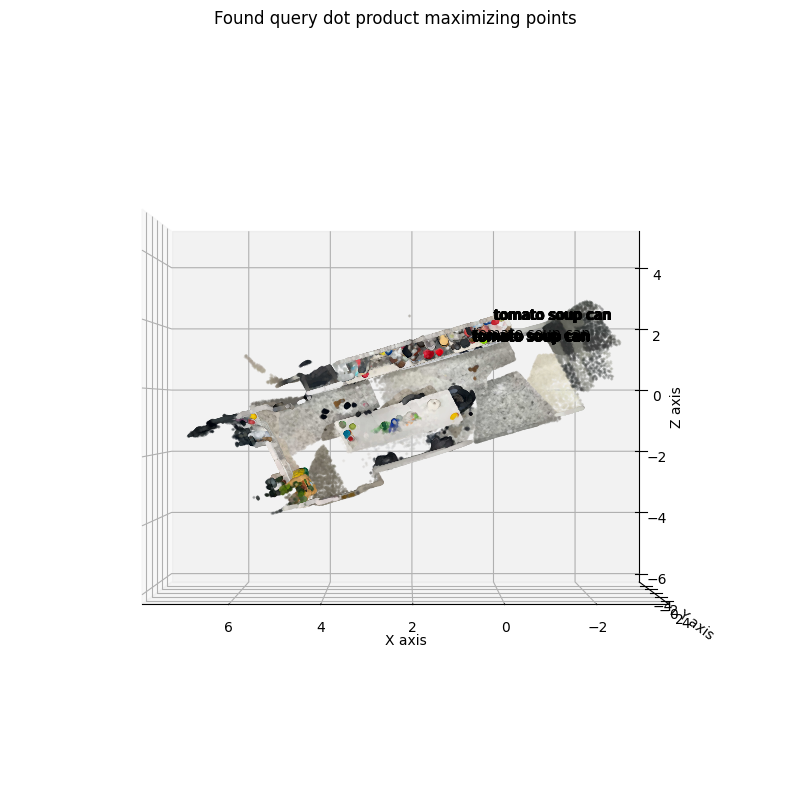

In [42]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(max_points[1][:30], [queries[1]] * 30),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)

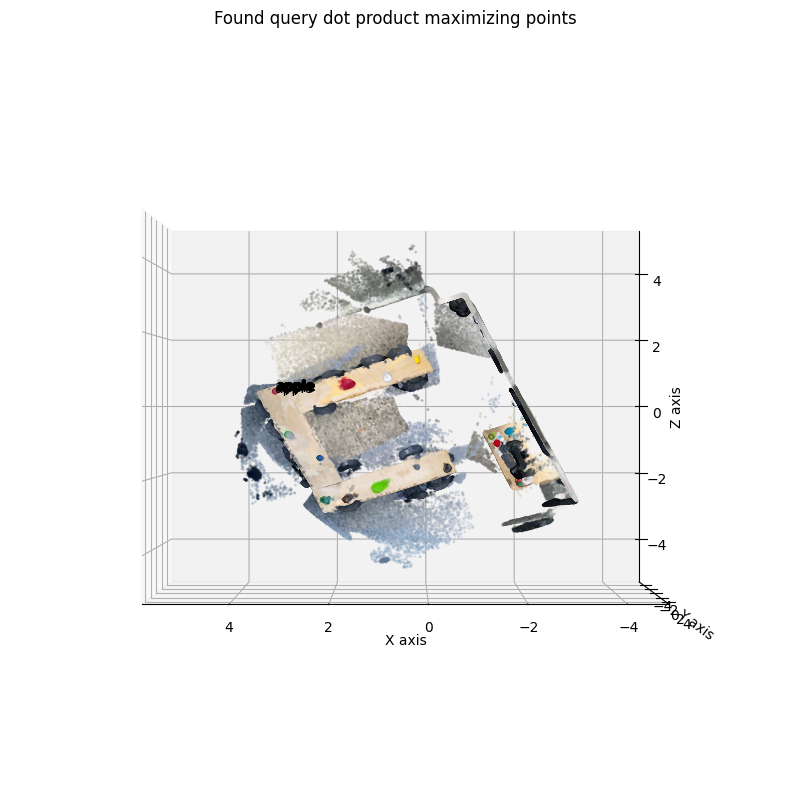

In [63]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(max_points[2][:10], [queries[2]] * 10),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)

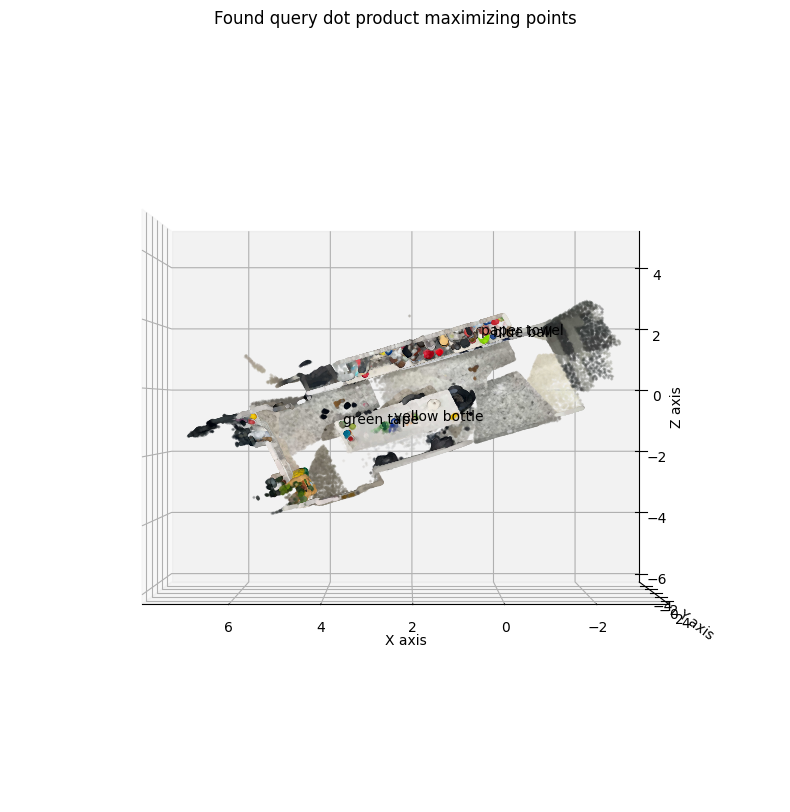

In [50]:
i = 4
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=90.,
    text=zip(torch.stack(max_points)[i: i+4, 0], queries[i: i+4]),
    title="Found query dot product maximizing points",
    goto=max_points_goto,
)

## (Extra) Aligning the point cloud to the ground plane
This horizonal plot helps us to figure out the translation between the ground plane and the scanned point cloud's ground plane, helpful if our robot planner needs to correct for the ground plane coordinates.

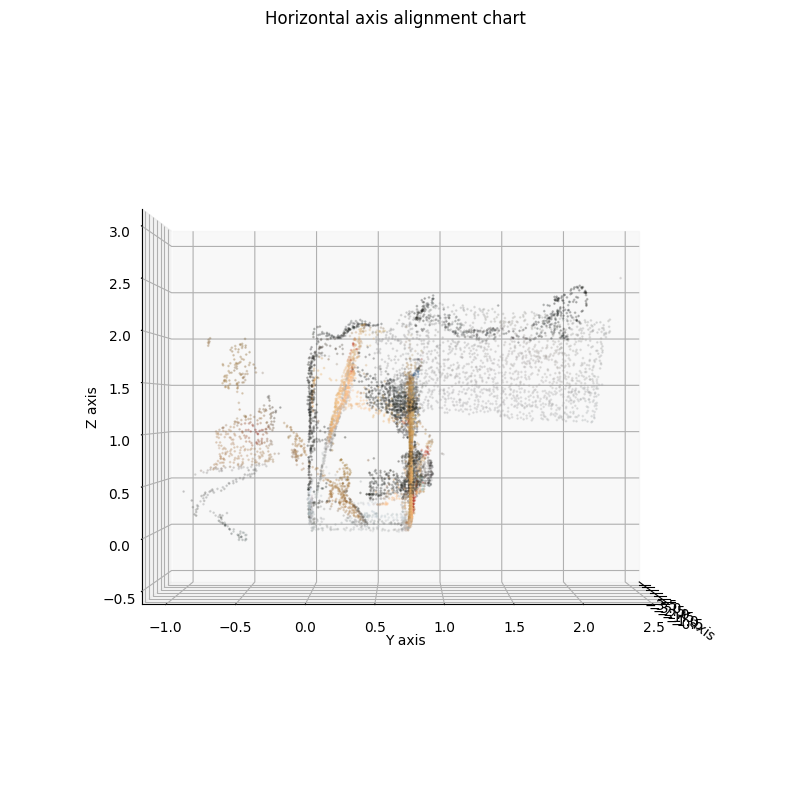

In [39]:
plot_with_matplotlib(
    cloud,
    width=800,
    height=500,
    background="black",
    mesh=False,
    use_as_color=["red", "green", "blue"],
    initial_point_size=None,
    cmap="hsv",
    polylines=None,
    linewidth=5,
    return_scene=False,
    output_name="pyntcloud_plot",
    elev=0.,
    azim=0.,
    title="Horizontal axis alignment chart",
)

Here we can see the ground plane is at around -1.5, which means we have to add 1.5 meters to the Z coordinate found by our model to run queries in the real world.